### **Assignment:**
take a dataset with two input features (X1, X2) and a target label (Y) that has three distinct classes (0, 1, and 2), and then create a neural network that can learn to predict the correct class for a given pair of input features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/CVPR/data.csv')
df.head()

,X1,X2,Y
0,340,485,0
1,440,399,0
2,216,164,1
3,498,58,0
4,498,12,0


In [4]:
df.shape

(500, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      500 non-null    int64
 1   X2      500 non-null    int64
 2   Y       500 non-null    int64
dtypes: int64(3)
memory usage: 11.8 KB


Normalization

In [6]:
def normalize(input, num_of_classes):
    vec = [0] * num_of_classes
    if 0 <= input < num_of_classes:
        vec[input] = 1
    return vec

In [7]:
X_1 = df['X1'].values.tolist()
X_2 = df['X2'].values.tolist()
Y = df['Y'].values.tolist()

In [8]:
X_1 = np.array(X_1)
X_2 = np.array(X_2)
Y = np.array(Y)

Scatter plot by class

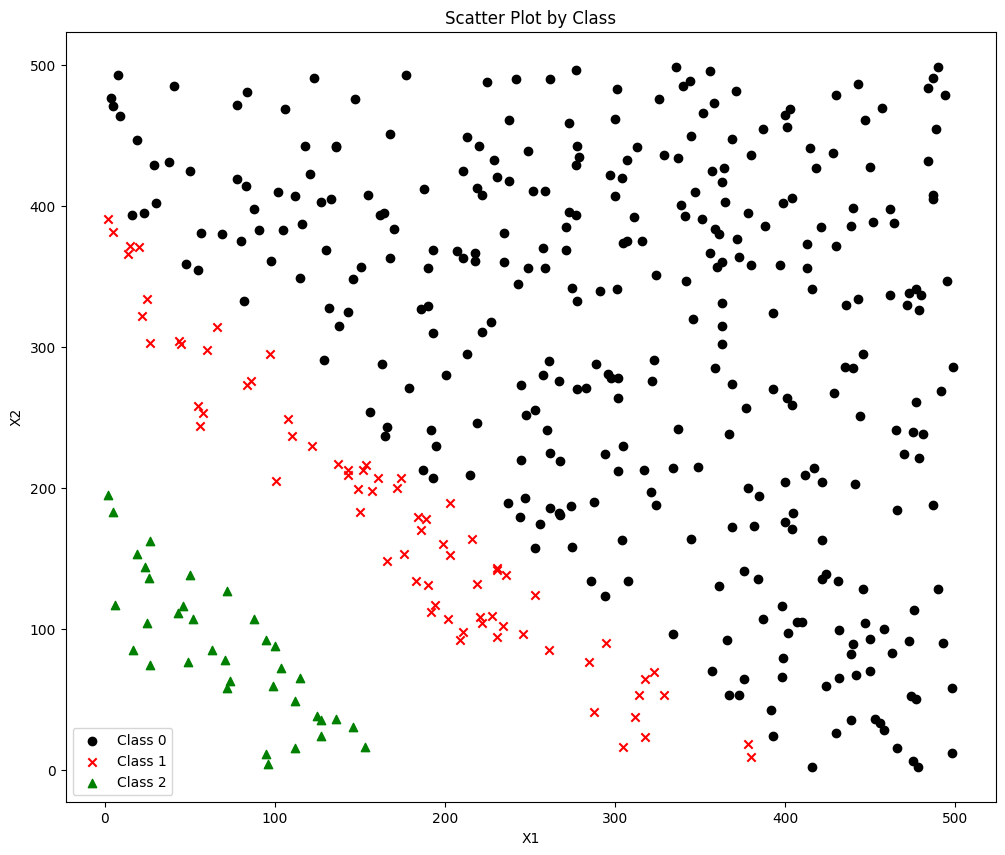

In [82]:
plt.figure(figsize=(12, 10))
plt.scatter(X_1[Y == 0], X_2[Y == 0], label='Class 0', marker='o', color='black')
plt.scatter(X_1[Y == 1], X_2[Y == 1], label='Class 1', marker='x', color='red')
plt.scatter(X_1[Y == 2], X_2[Y == 2], label='Class 2', marker='^', color='green')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot by Class')
plt.legend()
plt.show()

In [10]:
feat = list(zip(X_1, X_2))
feat_np = np.array(feat)

In [11]:
Y_ = []
for i in Y:
  Y_.append(normalize(i, 3))
Y_ = np.array(Y_)

Train Test Spilt

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feat_np, Y_, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (400, 2)
Test set shape: (100, 2)


In [13]:
X_train.shape, X_test.shape

((400, 2), (100, 2))

NN Class

In [18]:
class NN:
    def __init__(self, input_layer_neurons=2, hidden_layer_1_neurons=30,
                 hidden_layer_2_neurons=30, hidden_layer_3_neurons=30,
                 output_layer_neurons=3, learning_rate=0.001, activation_layer = 'relu'):
        self.learning_rate = learning_rate

        # weights
        self.W_H1I = np.random.randn(input_layer_neurons, hidden_layer_1_neurons) * 0.1
        self.W_H2H1 = np.random.randn(hidden_layer_1_neurons, hidden_layer_2_neurons) * 0.1
        self.W_H3H2 = np.random.randn(hidden_layer_2_neurons, hidden_layer_3_neurons) * 0.1
        self.W_OH3 = np.random.randn(hidden_layer_3_neurons, output_layer_neurons) * 0.1

        # biases
        self.biases = [
            np.zeros(hidden_layer_1_neurons),
            np.zeros(hidden_layer_2_neurons),
            np.zeros(hidden_layer_3_neurons),
            np.zeros(output_layer_neurons)
        ]

    # relu for hidden layers
    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    # softmax for output layer
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # FORWARD PROPAGATION
    def feedForward(self, X):
        self.hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.relu(self.hidden1_input)

        self.hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.relu(self.hidden2_input)

        self.hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.relu(self.hidden3_input)

        self.output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]
        self.output = self.softmax(self.output_input)

        return self.output

    # cross-entropy loss
    def compute_loss(self, Y, pred):
        m = Y.shape[0]
        return -np.sum(Y * np.log(pred + 1e-9)) / m

    # BACKPROPAGATION
    def backPropagation(self, X, Y, pred):
        m = X.shape[0]

        # Output layer delta (softmax + cross-entropy)
        output_delta = (pred - Y) / m  # shape (batch_size, output_neurons)

        # Hidden layers deltas
        hidden3_error = np.dot(output_delta, self.W_OH3.T)
        hidden3_delta = hidden3_error * self.relu(self.hidden3_output, der=True)

        hidden2_error = np.dot(hidden3_delta, self.W_H3H2.T)
        hidden2_delta = hidden2_error * self.relu(self.hidden2_output, der=True)

        hidden1_error = np.dot(hidden2_delta, self.W_H2H1.T)
        hidden1_delta = hidden1_error * self.relu(self.hidden1_output, der=True)

        # update weights
        self.W_OH3 -= self.learning_rate * np.dot(self.hidden3_output.T, output_delta)
        self.W_H3H2 -= self.learning_rate * np.dot(self.hidden2_output.T, hidden3_delta)
        self.W_H2H1 -= self.learning_rate * np.dot(self.hidden1_output.T, hidden2_delta)
        self.W_H1I -= self.learning_rate * np.dot(X.T, hidden1_delta)

        # update biases
        self.biases[3] -= self.learning_rate * np.sum(output_delta, axis=0)
        self.biases[2] -= self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[1] -= self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[0] -= self.learning_rate * np.sum(hidden1_delta, axis=0)

    def fit(self, X_train, Y_train, epochs, log_interval):
        self.train_loss_history = []
        self.x_axis = []

        for epoch in range(epochs):
            pred_train = self.feedForward(X_train)
            self.backPropagation(X_train, Y_train, pred_train)

            if epoch % log_interval == 0:
                train_loss = self.compute_loss(Y_train, pred_train)
                self.train_loss_history.append(train_loss)
                self.x_axis.append(epoch)
                print(f"Epoch {epoch}   | Train Loss: {train_loss:.4f}")

    def predict(self, X):
        pred = self.feedForward(X)
        return np.argmax(pred, axis=1)

In [19]:
nn_final = NN(learning_rate=0.0001)
nn_final.fit(X_train, y_train, epochs=100000, log_interval=10000)

Epoch 0   | Train Loss: 1.4516
Epoch 10000   | Train Loss: 0.7741
Epoch 20000   | Train Loss: 0.7483
Epoch 30000   | Train Loss: 0.7300
Epoch 40000   | Train Loss: 0.7168
Epoch 50000   | Train Loss: 0.7070
Epoch 60000   | Train Loss: 0.6996
Epoch 70000   | Train Loss: 0.6940
Epoch 80000   | Train Loss: 0.6897
Epoch 90000   | Train Loss: 0.6863


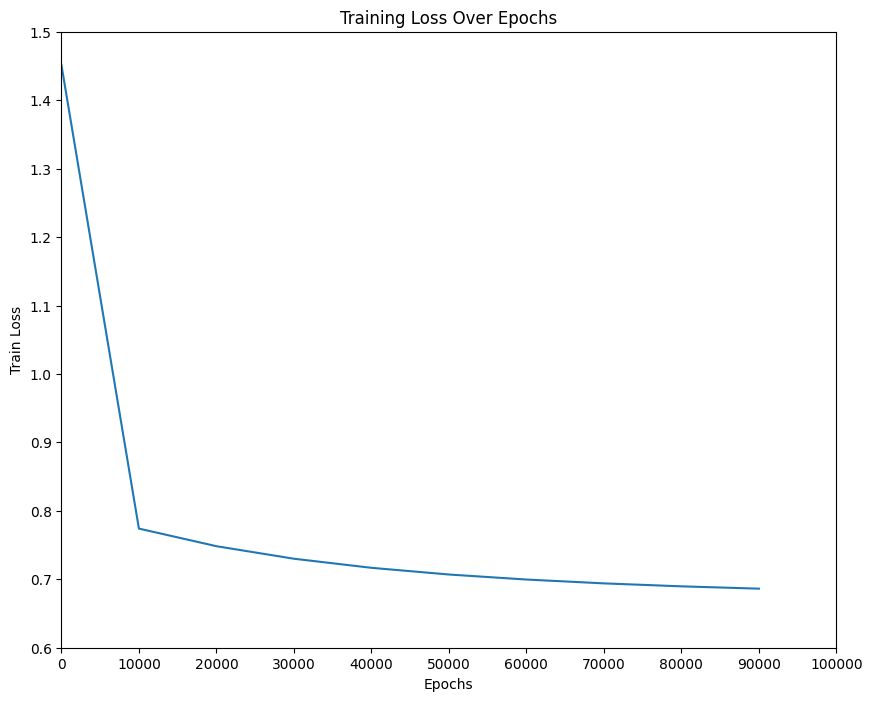

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(nn_final.x_axis, nn_final.train_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlim(0, 100000)
plt.ylim(0.6, 1.5)
plt.xticks(range(0, 100001, 10000))
plt.yticks(np.arange(0.6, 1.51, 0.1))
plt.show()

In [31]:
y_pred_test = nn_final.predict(X_test)
y_true_test = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_test == y_true_test)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.81


In [43]:
def getProb(pred):
    return {f'Class-{index}': p*100 for index, p in enumerate(pred)}

def getClass(dict):
  max_key = max(dict, key=dict.get)
  return (max_key)

In [73]:
input_data = np.array([[77, 1]])
pred = nn_final.feedForward(input_data)

probabilities = pred[0]
probability_dict = getProb(probabilities)
predicted_class = getClass(probability_dict)

print("Prediction Output:")
print(f"Raw Probabilities: {probabilities}")
print("\nClass Probabilities:")
for class_name, probability in probability_dict.items():
    print(f"  {class_name}: {probability:.2f}%")

print(f"\nPredicted Class: {predicted_class}")

Prediction Output:
Raw Probabilities: [0.76661351 0.09096766 0.14241883]

Class Probabilities:
  Class-0: 76.66%
  Class-1: 9.10%
  Class-2: 14.24%

Predicted Class: Class-0


In [78]:
predictions = nn_final.feedForward(X_test)

y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Total Accuracy: {accuracy:.4f}")

precision = precision_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score:.4f}")

recall = recall_score(y_true_labels, y_pred_labels, average='macro')
print(f"Recall (macro average): {recall:.4f}")

f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
print(f"F1 Score (macro average): {f1:.4f}")

Total Accuracy: 0.8100
Precision for each class:
Class 0: 0.8100
Class 1: 0.0000
Class 2: 0.0000
Recall (macro average): 0.3333
F1 Score (macro average): 0.2983
